# digital narratives of COVID-19: frequency bar chart

In this notebook we demonstrate how to use *coveet*, a Python script that retrieves basic statistics (most frequent words, bigrams, trigrams, top users, hashtags) from our curated COVID-19 database about our collection. We visualize the results using bar charts to get a sense of top words/bigrams/trigrams/ec. over the span of a week in each geographic area. Please feel free to modify this notebook or, if you would like to preserve this version, make a copy of it by clicking "File" > "Make a Copy..."

To follow along, we recommend running the script portions piecemeal, in order.

__Author:__

* Jerry Bonnell, [j.bonnell@miami.edu](mailto:j.bonnell@miami.edu)



## 0. Setting Up

Before we get started, let's set up the notebook by importing libraries we need.

In [3]:
import numpy as np
import pandas as pd
from coveet import count_ngrams
from collections import Counter
import matplotlib.pyplot as plt

## 1. Querying the database API

We first use coveet to query one week of tweets written in each geographic area. All of the geolocated tweets are written in Spanish, with the exception of Florida where both Spanish and English tweets are obtained. 

In [1]:
!python3 coveet.py query -g fl ar co ec es mx pe -l en es -d 2020-05-08 2020-05-14

Namespace(date=[datetime.datetime(2020, 5, 8, 0, 0), datetime.datetime(2020, 5, 14, 0, 0)], func=<function handle_query at 0x12f03af80>, geo=['fl', 'ar', 'co', 'ec', 'es', 'mx', 'pe'], lang=['en', 'es'])
wrote df to dhcovid_2020-5-8_to_2020-5-14_es_en_fl_ec_mx_pe_co_ar_es.csv!


The coveet script just wrote the results to a CSV file called `dhcovid_2020-5-8_to_2020-5-14_es_en_fl_ec_mx_pe_co_ar_es.csv`. Let's load in this CSV using `pandas`.

In [26]:
df = pd.read_csv('dhcovid_2020-5-8_to_2020-5-14_es_en_fl_ec_mx_pe_co_ar_es.csv', index_col=0)

Let's have a look at what this dataframe looks like...

In [27]:
df

,date,lang,geo,text,hashtags
0,2020-05-08,es,fl,muere enfermero cubano atendia pacientes caribe,NaN
1,2020-05-08,es,fl,trump desmonta incursion frustrada regimen man...,#08may #internacionales #cambioweb #covid19
2,2020-05-08,es,fl,muere niño 5 años nueva york enfermedad vinculada,#covid
3,2020-05-08,es,fl,corresponsal medico principal explico cuales f...,#diariodelcoronavirus
4,2020-05-08,es,fl,puede quedarse siempre advertencia cientifico ...,#08may #internacionales #cambioweb #covid19
5,2020-05-08,es,fl,atravesaron espacio aereo homenaje miembros sa...,#blueangels #surdelaflorida #covid19
6,2020-05-08,es,fl,semana ingreso hospital sintomas esposa pide h...,NaN
7,2020-05-08,es,fl,harley tuerto perrito apoya medicos mexico com...,NaN
8,2020-05-08,es,fl,abuelita 102 años gano batalla dada alta mexico,NaN
9,2020-05-08,es,fl,medica recuperada pide hispanos miedo ir hospi...,#diariodelcoronavirus


Nice :-) Let's do some quick pre-processing of this dataframe in preparation for the visualization task. Namely, we are going to convert the date column to a `datetime` object since that makes working with dates easier. We will also subset the dataframe columns to include only `date`, `lang`, `geo`, and `text` as these are the ones we are interested in for this notebook. 

In [28]:
df['date'] = pd.to_datetime(df['date'])
df = df[['date', 'lang', 'geo', 'text']]
df.dropna(inplace=True)

/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until


## 2. Visualization

Now we're ready to visualize! Let's have a look at the top 10 words in each area. First, we define some variables.

In [32]:
top_n = 10  # top 10 words
n_gram = 1  # ask for word frequency (i.e. an n-gram where n=1)

We will create a dictionary where each key is a location-language pair, and the value is a list of the top occurrences under that setting. The code here invokes a function `count_ngrams()` from coveet to prepare the top n-gram information. 

A brief note on how these n-grams are obtained: I treat the full tweet as context, rather than adjacent neighbors, in light of how short a "tweet" unit is. For instance, when obtaining bigrams, I consider the occurrence of two words together in a tweet as bigrams, not just adjacent words. This could lead to more interesting results, but we should discuss. 

In [33]:
# location, language, actual tuples
counts = {(g, l): Counter(count_ngrams(t, n_gram)).most_common(top_n)
          for (g, l), t in df.groupby(["geo", "lang"])['text']}
print(counts)

{('ar', 'es'): [(('casos',), 1789), (('mas',), 1490), (('pandemia',), 920), (('si',), 860), (('coronavirus',), 823), (('nuevos',), 766), (('hoy',), 727), (('salud',), 629), (('argentina',), 622), (('pais',), 582)], ('co', 'es'): [(('casos',), 4577), (('mas',), 4569), (('salud',), 2648), (('pandemia',), 2370), (('colombia',), 2189), (('si',), 2122), (('hoy',), 2001), (('nuevos',), 1889), (('mayo',), 1867), (('coronavirus',), 1866)], ('ec', 'es'): [(('mas',), 1357), (('casos',), 1019), (('salud',), 923), (('ecuador',), 726), (('pandemia',), 722), (('si',), 653), (('contagio',), 603), (('mayo',), 558), (('emergencia',), 542), (('pais',), 517)], ('es', 'es'): [(('mas',), 5120), (('crisis',), 3513), (('si',), 2530), (('coronavirus',), 2275), (('españa',), 2174), (('pandemia',), 1962), (('hoy',), 1722), (('gobierno',), 1652), (('frente',), 1610), (('medidas',), 1501)], ('fl', 'en'): [(('us',), 402), (('pandemic',), 352), (('new',), 341), (('people',), 268), (('coronavirus',), 265), (('may',)

Now we'll write some `matplotlib` code to create a matrix of bar charts, one for each location-language pair.

In [34]:
from pylab import rcParams
rcParams['figure.figsize'] = 40, 40  # setting figure size
plt.rcParams.update({'font.size': 22})  # setting font size

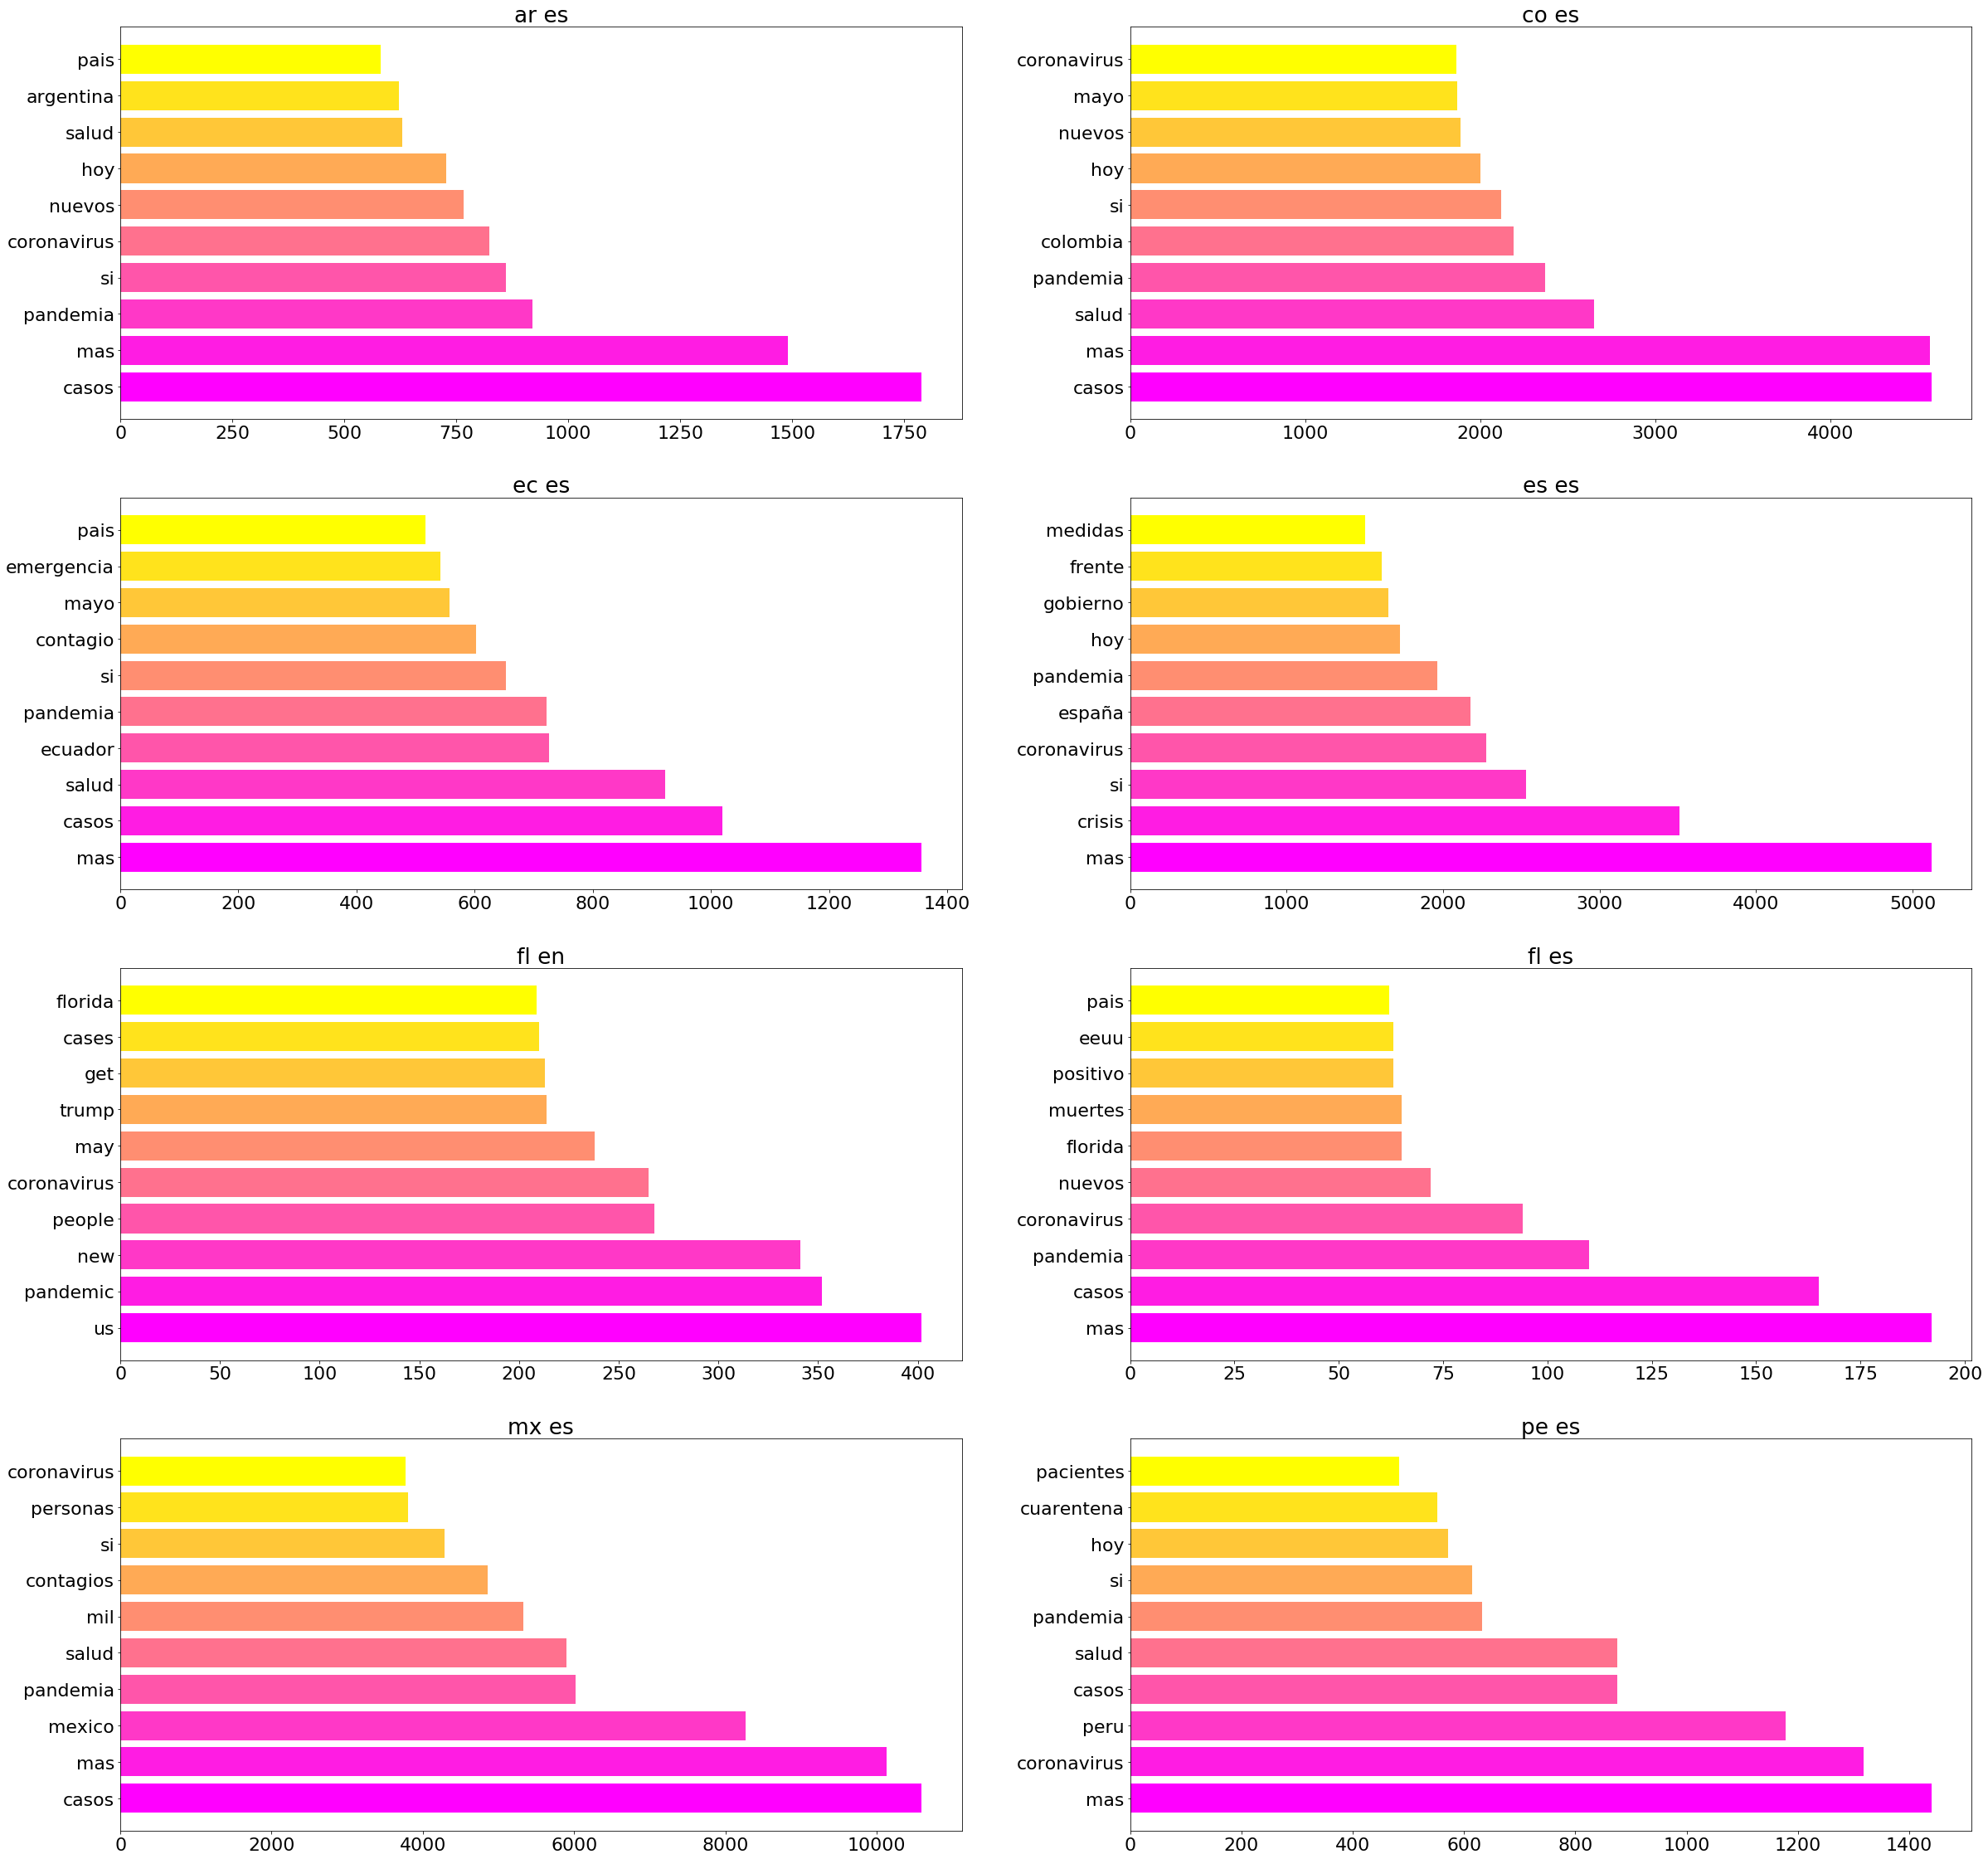

In [35]:
fig, axes = plt.subplots(4,2)
flattened = axes.flatten()
for i, ((geo, lang), geo_counts) in enumerate(counts.items()):
    labels = [" ".join(w) for w, _ in geo_counts]
    y = [n for _, n in geo_counts]
    cmap = plt.get_cmap('spring')
    colors = plt.get_cmap('spring')(np.linspace(0, 1, len(labels)))
    flattened[i].set_title(f"{geo} {lang}")
    flattened[i].barh(y=range(0,10), width=y, color=colors, tick_label=labels)